# Hyperspectral Examples

In [1]:
import podpac as pc
import traitlets as tl
import rasterio
import numpy as np
# from podpac.data import Rasterio
%matplotlib inline

In [2]:
directory = 'EO1H0380292016366110KF'
testfile = directory + '/EO1H0380292016366110KF_B018_L1GST.tif'

In [3]:
bounds = pc.Coordinates([
    pc.clinspace(49.25, 39.75, 100), 
    pc.clinspace(-116.75, -95.25, 100)
    ], 
    dims=['lat', 'lon']
)

In [4]:
class HyperionBandSource(pc.data.Rasterio):
    # parameters
    source = tl.Unicode()
    
    # attributes
    dataset = tl.Any()
    interpolation = pc.data.interpolation_trait(default_value={
        'method': 'nearest',
        'interpolators': [pc.interpolators.Rasterio, pc.interpolators.ScipyGrid, pc.interpolators.ScipyPoint]
    })
    spectral_band = tl.Unicode()
    
    @tl.default('spectral_band')
    def _get_spectral_band(self):
        return self.source.split('_')[1]
    
    @tl.default('dataset')
    def _open_dataset(self):
        """Opens the data source"""
        dataset = super(HyperionBandSource, self)._open_dataset()
        reprojected_dataset = self._reproject(dataset, {'init': 'epsg:4326'})  # reproject dataset into WGS84
#         reprojected_dataset.update_tags(1, band=source.split('_')[1])
        return reprojected_dataset
    
    def _reproject(self, src_dataset, dst_crs):
        # https://rasterio.readthedocs.io/en/latest/topics/reproject.html#reprojecting-a-geotiff-dataset
         
        # calculate default transform
        transform, width, height = rasterio.warp.calculate_default_transform(src_dataset.crs,
                                                                             dst_crs,
                                                                             src_dataset.width,
                                                                             src_dataset.height,
                                                                             *src_dataset.bounds)

        kwargs = src_dataset.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # write out new file with new projection
        with rasterio.MemoryFile() as f:
            with f.open(**kwargs) as dataset:
                for i in range(1, src_dataset.count + 1):
                    rasterio.warp.reproject(
                        source=rasterio.band(src_dataset, i),
                        destination=rasterio.band(dataset, i),
                        src_transform=src_dataset.transform,
                        src_crs=src_dataset.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs)
            return f.open()


In [5]:
node = HyperionBandSource(source=testfile)

In [6]:
node.spectral_band

'B018'

In [7]:
o = node.eval(node.native_coordinates)

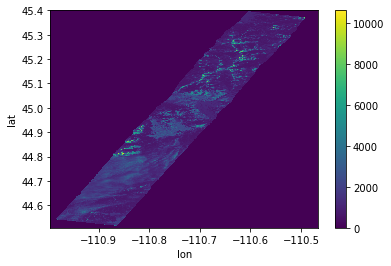

In [8]:
o.plot()

In [73]:
node.tags

AttributeError: 'Hyperion' object has no attribute 'tags'